# Bayesian presidential election forecasting model
Here we'll consider a simple Bayesian model for the 2016 presidential election based on polling data aggregated by FiveThirtyEight.

First, we'll download the polling data in CSV format and do some re-formatting:

In [1]:
import pandas as pd
import numpy as np
import datetime
import pymc3 as pm


LATEST_POLL_DATE = datetime.datetime(2016, 10, 28)
polls = pd.read_csv('http://projects.fivethirtyeight.com/general-model/president_general_polls_2016.csv',
                    parse_dates=['startdate', 'enddate'])
polls = polls[polls.enddate > LATEST_POLL_DATE]
polls = polls[['state', 'adjpoll_clinton', 'adjpoll_trump']]

# Remove national polls and combine polls for individual congressional districts
polls = polls[polls.state != 'U.S.']
polls.state = polls.state.replace(' CD.*', '', regex=True)

We'll also need the number of electoral college votes for each state in order to make predictions about the overall winner:

In [2]:
states = pd.read_csv('https://raw.githubusercontent.com/bnaul/python-seminar/master/DataFiles_and_Notebooks/10_MCMC_and_Symbolic/electoral_votes.csv')
states.head()

,abbr,state,votes
0,AL,Alabama,9
1,AK,Alaska,3
2,AZ,Arizona,11
3,AR,Arkansas,6
4,CA,California,55


In order to make sure we have a decent sample size, we'll count the number of polls per state:

In [3]:
counts_by_state = polls.state.value_counts()
states = states.merge(pd.DataFrame({'poll_count': counts_by_state}), left_on='state', right_index=True)
states.sort_values(by='poll_count').head()

,abbr,state,votes,poll_count
50,WY,Wyoming,3,18
39,RI,Rhode Island,4,18
8,DC,District of Columbia,3,18
1,AK,Alaska,3,18
47,WA,Washington,12,21


We'll use the following simple model for our polling data: 

- Let $\mu_C$ and $\mu_T$ represent Clinton's and Trump's national levels of support, respectively
- Let $\mu_C^{(i)}$ and $\mu_T^{(i)}$ represent their support within state $i$
- We'll then treat each poll from state $i$ as a sample from a normal distribution centered around each candidate's support there

To more easily link states with their model parameters, we'll add an index column `i`:

In [4]:
states['i'] = states.index
polls = polls.merge(states[['state', 'i']], on='state')
polls.head()

,state,adjpoll_clinton,adjpoll_trump,i
0,Wisconsin,45.76629,41.22703,49
1,Wisconsin,46.83770,40.14658,49
2,Wisconsin,45.68810,41.17081,49
3,Wisconsin,43.51396,42.91862,49
4,Wisconsin,44.70177,39.46035,49


Now we're ready to define our `pymc3` model:

In [5]:
with pm.Model() as model:
    # Prior distributions for national- and state-level support
    mu_C = pm.Normal('mu_C', mu=42., sd=2.)
    mu_C_state = pm.Normal('mu_C_state', mu=mu_C, sd=2., shape=51)
    mu_T = pm.Normal('mu_T', mu=42., sd=2.)
    mu_T_state = pm.Normal('mu_T_state', mu=mu_T, sd=2., shape=51)

    # Select the appropriate state-level variable for each poll
    mu_C_poll = pm.Deterministic('mu_C_poll', mu_C_state[polls.i])
    mu_T_poll = pm.Deterministic('mu_T_poll', mu_T_state[polls.i])
    
    # Gaussian likelihood for polling data
    C_polls = pm.Normal('C_polls', mu=mu_C_poll, sd=5., observed=polls.adjpoll_clinton)
    T_polls = pm.Normal('T_polls', mu=mu_T_poll, sd=5., observed=polls.adjpoll_trump)

Our goal is to model posterior distribution of parameters given observed data:
1. Choose a MCMC sampler (defaults are NUTS/Metropolis-Hastings)
2. Run chain for a while to reduce correlation with starting value ("burn-in")
3. Take every $n$th step as samples from the approximate posterior ("thinning")

In [6]:
N = int(1e5)
burn_in_frac = 0.1
thin_factor = 5

with model:
    step = pm.Metropolis()
    trace = pm.sample(N, step=step, njobs=1)
    
burned_in = trace[int(burn_in_frac * N):]
samples = burned_in[::thin_factor]

100%|██████████| 100000/100000 [00:39<00:00, 2536.69it/s]


We'll use the `chorogrid` tool (https://github.com/Prooffreader/chorogrid) to visualize results using a map of the U.S.:

In [7]:
!pip install -q chorogrid
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import chorogrid as cg


def us_choropleth(state_df, column, fenceposts=None, map_type='map'):
    """Draw a U.S. map color-coded by `state_df[column]`."""
    # Hard-coded FiveThirtyEight color palette
    colors = ['#fc6b5e', '#fd998a', '#fec2b6', '#fee7e2', '#e2edfb', '#b3d4f5', '#7fbaf0', '#33a2e9']
    mybin = cg.Colorbin(state_df[column], colors, proportional=True, decimals=None)
    mybin.set_decimals(2)
    if fenceposts is not None:
        mybin.fenceposts = fenceposts
    mybin.recalc(fenceposts=False)
    colors_by_state = mybin.colors_out
    font_colors_by_state = mybin.complements
    legend_colors = mybin.colors_in
    legend_labels = mybin.labels
    usa_states_file = os.path.join(os.path.dirname(cg.__file__), 'databases', 'usa_states.csv')
    grid = cg.Chorogrid(usa_states_file, state_df.abbr, colors_by_state)
    if map_type == 'map':
        grid.draw_map(spacing_dict={'legend_offset': [-150, -25]})
    elif map_type == 'hex':
        grid.draw_hex(spacing_dict={'legend_offset': [-150, -25]})
    else:
        raise NotImplementedError("Unrecognized map type.")
    grid.done(show=True)

Our estimate of the probability that Clinton/Trump wins a given state is simply the number of realizations in which that candidate's share of the vote is higher:

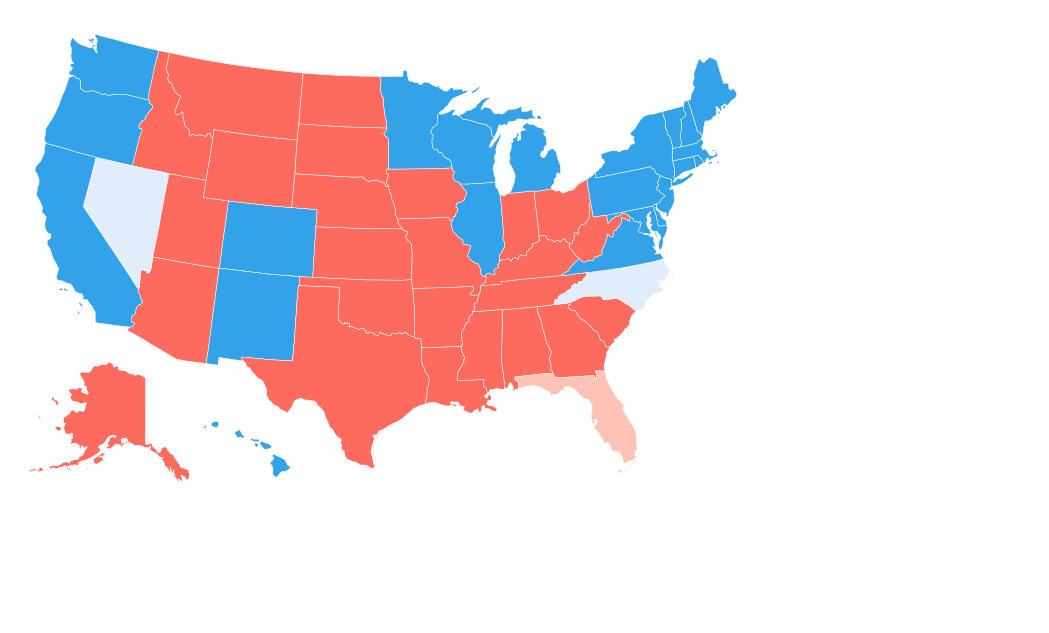

In [8]:
states['prob_clinton'] = (samples['mu_C_state'] > samples['mu_T_state']).mean(axis=0)
us_choropleth(states, 'prob_clinton', map_type='map')

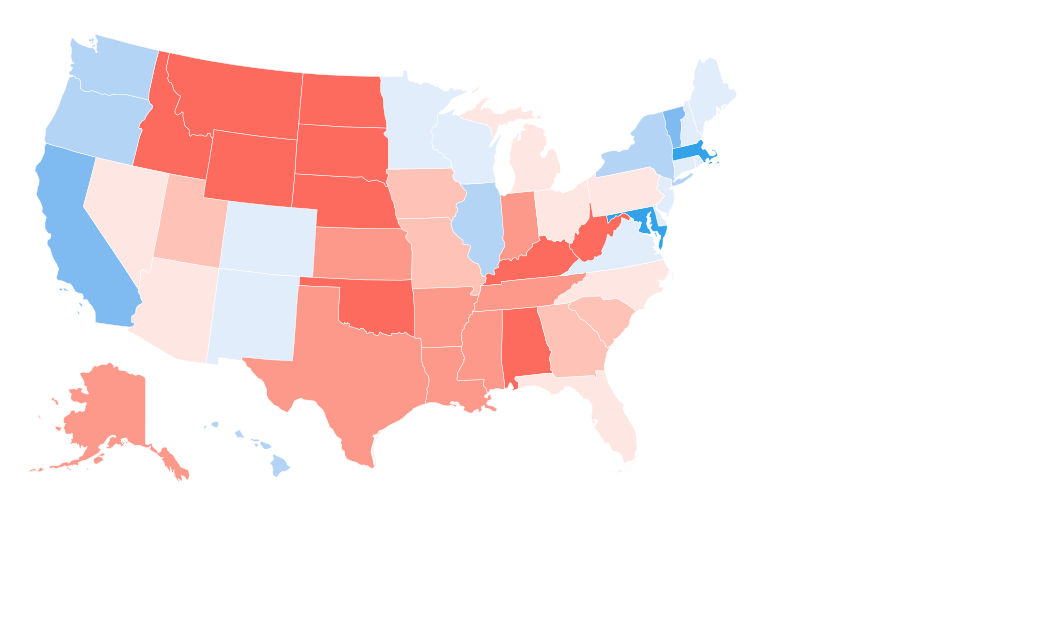

Electoral college: Clinton 294, Trump 244


In [28]:
j = np.random.randint(len(samples))
states['vote_diff'] = samples['mu_C_state'][j] - samples['mu_T_state'][j]
clinton_votes = np.sum(states.votes * (states['vote_diff'] > 0))
trump_votes = np.sum(states.votes * (states['vote_diff'] < 0))
us_choropleth(states, 'vote_diff', fenceposts=np.linspace(-20, 20, 8), map_type='map')
print("Electoral college: Clinton {}, Trump {}".format(clinton_votes, trump_votes))

If we only care about who wins the electoral college, then we should calculate the number of votes in each sample and examine that distribution:

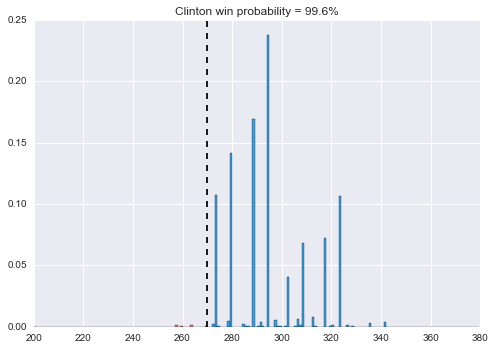

In [15]:
clinton_votes = np.sum(np.atleast_2d(states.votes)
                       * (samples['mu_C_state'] > samples['mu_T_state']), axis=1)
trump_votes = np.sum(np.atleast_2d(states.votes)
                     * (samples['mu_C_state'] < samples['mu_T_state']), axis=1)

n, bins, patches = plt.hist(clinton_votes, bins=np.arange(200, 380), normed=True, color='#33a2e9')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c, p in zip(bin_centers, patches):
    if c < 270:
        plt.setp(p, 'facecolor', '#fc6b5e')
plt.axvline(270, color='k', ls='dashed')
plt.title("Clinton win probability = {:2.1f}%".format(100 * (clinton_votes > 270).mean()));

The `forestplot` function from `pmyc3` can show the distribution of the vote for each state:

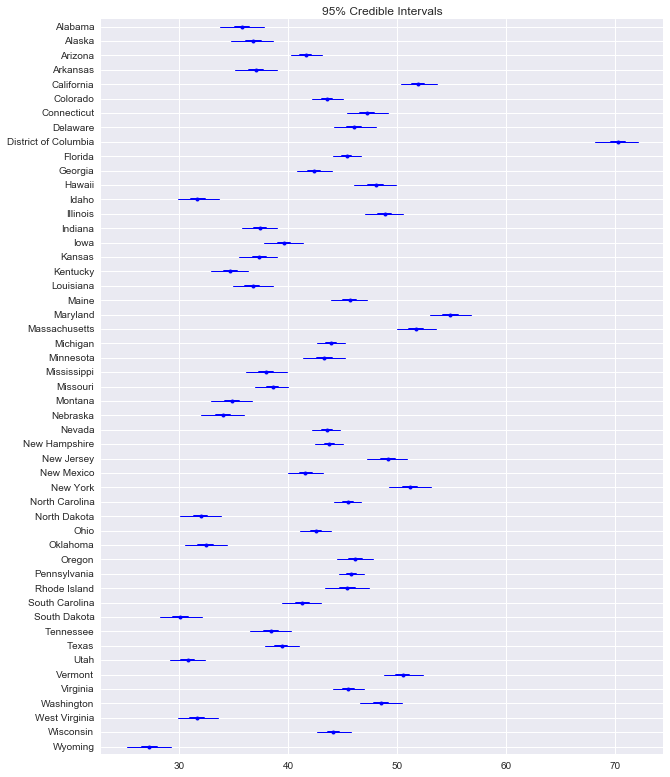

In [13]:
plt.figure(figsize=(12, 12))
pm.forestplot(samples, varnames=['mu_C_state'], ylabels=states.state);